In [1]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

/home/sarim.hashmi/anaconda3/envs/AI702/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sarim.hashmi/anaconda3/envs/AI702/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


/home/sarim.hashmi/anaconda3/envs/AI702/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


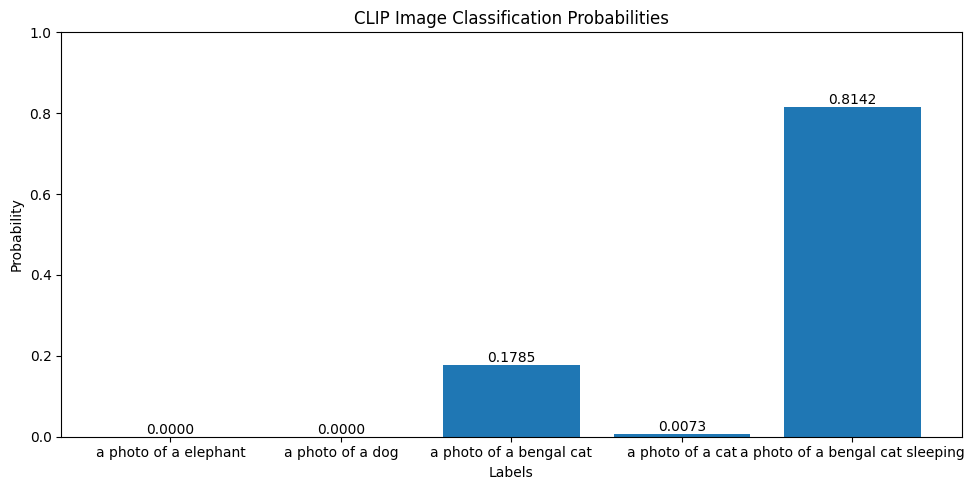

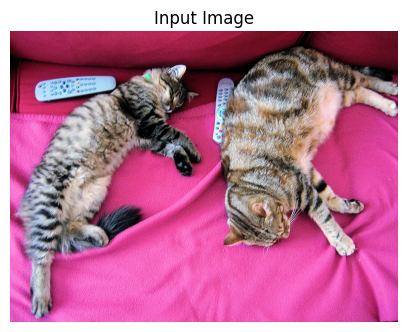

In [6]:
from PIL import Image
import requests
import matplotlib.pyplot as plt

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

labels = ["a photo of a elephant", "a photo of a dog" , "a photo of a bengal cat", "a photo of a cat" , "a photo of a bengal cat sleeping"]
inputs = processor(text=labels, images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

# Visualization
plt.figure(figsize=(10, 5))
plt.bar(labels, probs[0].detach().numpy())
plt.title("CLIP Image Classification Probabilities")
plt.xlabel("Labels")
plt.ylabel("Probability")
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1

for i, prob in enumerate(probs[0]):
    plt.text(i, prob.item(), f"{prob.item():.4f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Display the image
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis('off')
plt.title("Input Image")
plt.show()

### lets deal with cifar 10 dataset and use zero shot using clip and generate graph for the accuracy for each class 


Files already downloaded and verified


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


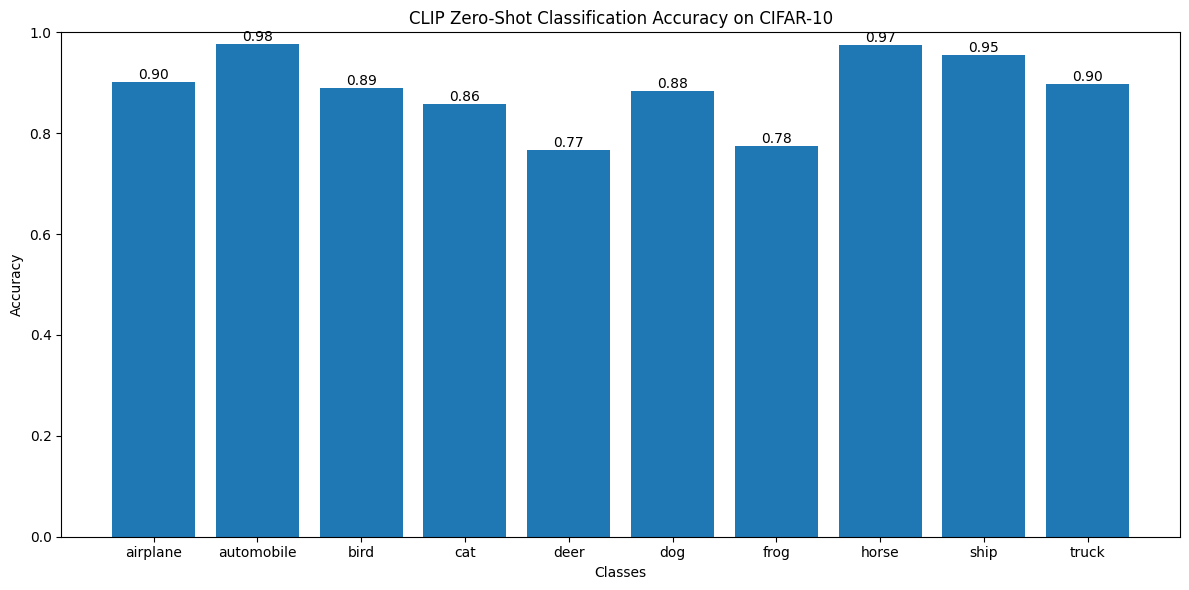

Overall Accuracy: 0.8875


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from transformers import CLIPProcessor, CLIPModel

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Load CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# CIFAR-10 classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Prepare text inputs
text_inputs = processor(text=["a photo of a " + c for c in classes], padding=True, return_tensors="pt")

correct_predictions = {c: 0 for c in classes}
total_predictions = {c: 0 for c in classes}

# Evaluate on test set
model.eval()
with torch.no_grad():
    for images, labels in testloader:
        batch_size = images.shape[0]
        
        # Process images
        images = [(img.permute(1, 2, 0).numpy() * 0.5 + 0.5) * 255 for img in images]
        images = [Image.fromarray(img.astype(np.uint8)) for img in images]
        image_inputs = processor(images=images, return_tensors="pt", padding=True)
        
        # Get model outputs
        outputs = model(**image_inputs, **text_inputs)
        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=1)
        
        # Get predictions
        predictions = torch.argmax(probs, dim=1)
        
        # Update correct predictions and total predictions
        for pred, label in zip(predictions, labels):
            pred_class = classes[pred]
            true_class = classes[label]
            total_predictions[true_class] += 1
            if pred_class == true_class:
                correct_predictions[true_class] += 1

# Calculate accuracy for each class
accuracies = {c: correct_predictions[c] / total_predictions[c] for c in classes}

# Plot results
plt.figure(figsize=(12, 6))
plt.bar(classes, list(accuracies.values()))
plt.title("CLIP Zero-Shot Classification Accuracy on CIFAR-10")
plt.xlabel("Classes")
plt.ylabel("Accuracy")
plt.ylim(0, 1)

for i, (c, acc) in enumerate(accuracies.items()):
    plt.text(i, acc, f"{acc:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print overall accuracy
overall_accuracy = sum(correct_predictions.values()) / sum(total_predictions.values())
print(f"Overall Accuracy: {overall_accuracy:.4f}")

Files already downloaded and verified


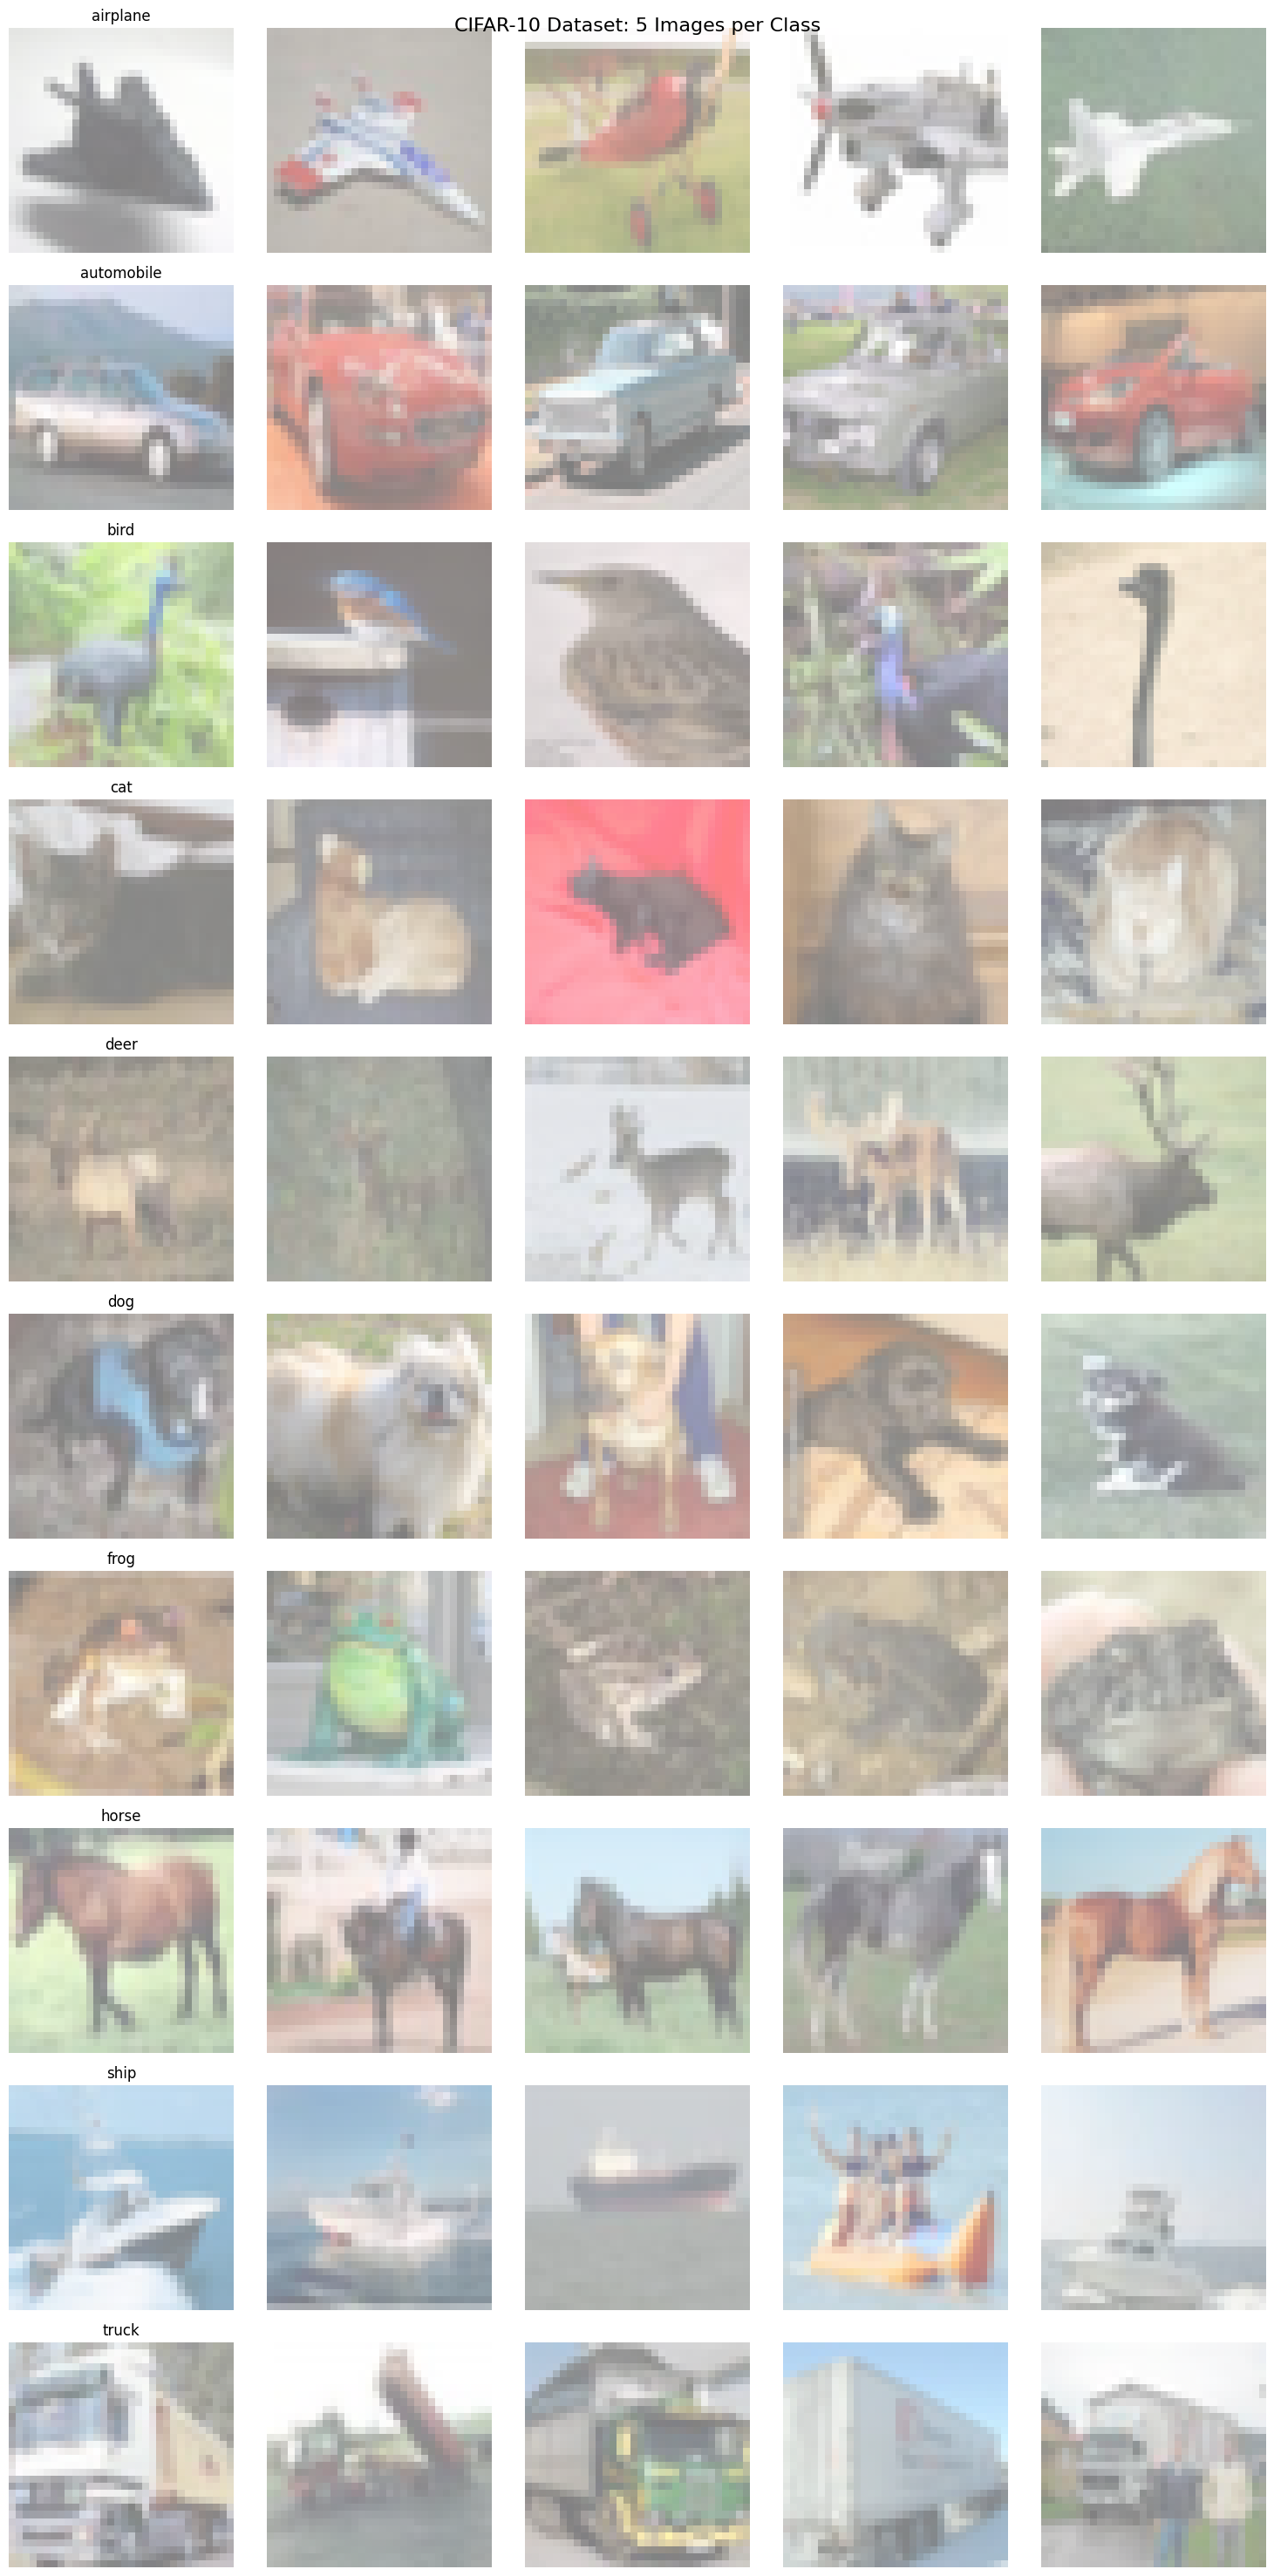

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# CIFAR-10 classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Function to show image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

# Create a dictionary to store images for each class
class_images = {c: [] for c in classes}

# Collect 5 images for each class
for img, label in trainset:
    class_name = classes[label]
    if len(class_images[class_name]) < 5:
        class_images[class_name].append(img)
    
    if all(len(imgs) == 5 for imgs in class_images.values()):
        break

# Plot the images
fig, axs = plt.subplots(10, 5, figsize=(15, 30))
fig.suptitle("CIFAR-10 Dataset: 5 Images per Class", fontsize=16)

for i, class_name in enumerate(classes):
    for j, img in enumerate(class_images[class_name]):
        axs[i, j].imshow(imshow(img))
        axs[i, j].axis('off')
        if j == 0:
            axs[i, j].set_title(class_name)

plt.tight_layout()
plt.show()

Files already downloaded and verified


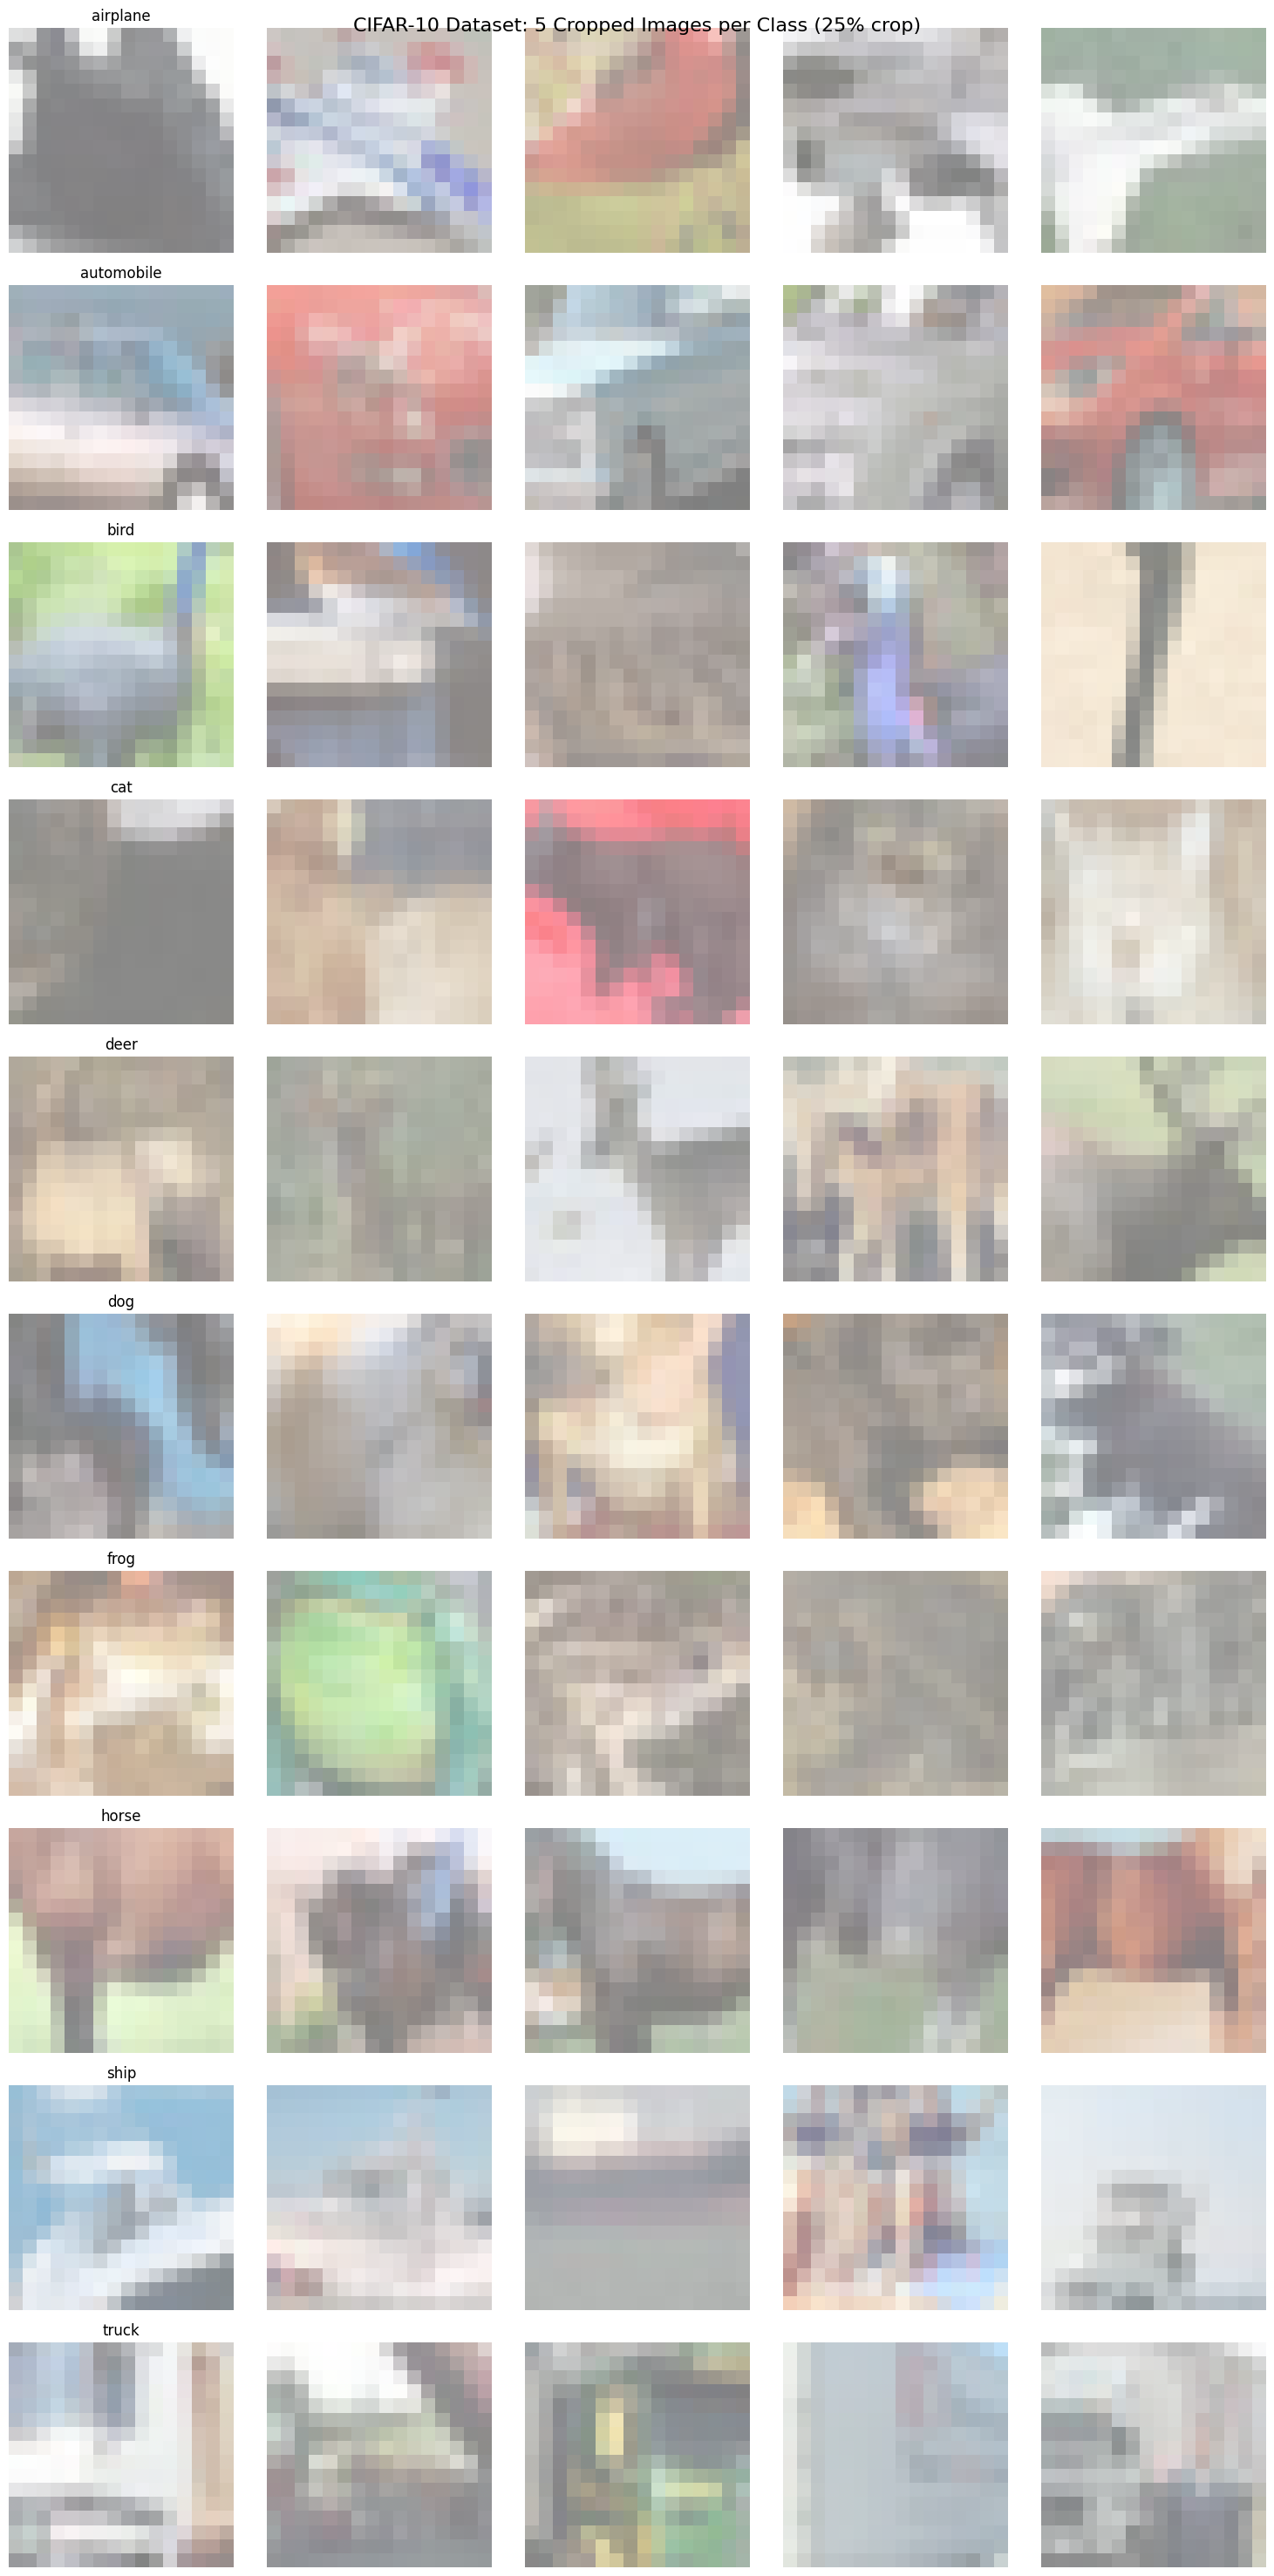

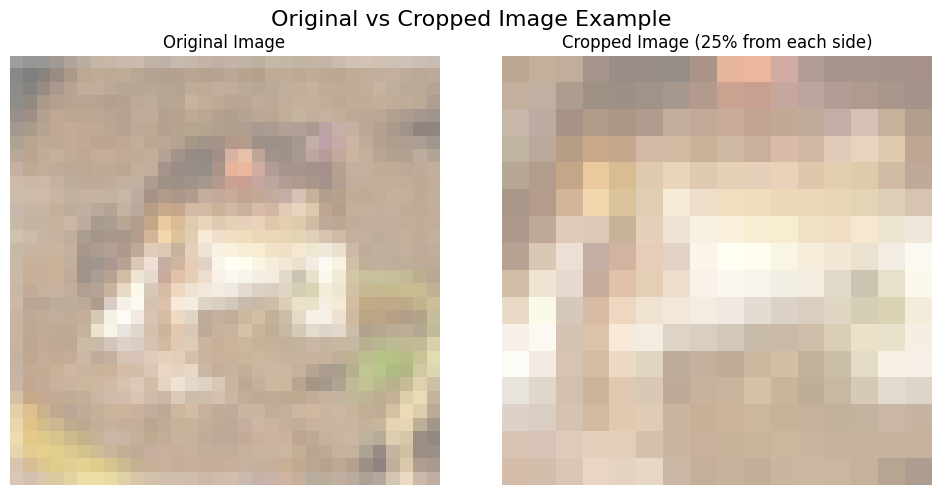

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# CIFAR-10 classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Function to show image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

# Function to crop image
def crop_image(img, crop_percent=0.25):
    _, h, w = img.shape
    crop_h = int(h * crop_percent)
    crop_w = int(w * crop_percent)
    return img[:, crop_h:h-crop_h, crop_w:w-crop_w]

# Create a dictionary to store images for each class
class_images = {c: [] for c in classes}

# Collect 5 images for each class
for img, label in trainset:
    class_name = classes[label]
    if len(class_images[class_name]) < 5:
        # Crop the image
        cropped_img = crop_image(img)
        class_images[class_name].append(cropped_img)
    
    if all(len(imgs) == 5 for imgs in class_images.values()):
        break

# Plot the images
fig, axs = plt.subplots(10, 5, figsize=(15, 30))
fig.suptitle("CIFAR-10 Dataset: 5 Cropped Images per Class (25% crop)", fontsize=16)

for i, class_name in enumerate(classes):
    for j, img in enumerate(class_images[class_name]):
        axs[i, j].imshow(imshow(img))
        axs[i, j].axis('off')
        if j == 0:
            axs[i, j].set_title(class_name)

plt.tight_layout()
plt.show()

# Visualize original vs cropped image
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Original vs Cropped Image Example", fontsize=16)

# Get a random image
random_class = np.random.choice(classes)
random_img, _ = next(iter(trainset))

# Original image
axs[0].imshow(imshow(random_img))
axs[0].set_title("Original Image")
axs[0].axis('off')

# Cropped image
cropped_img = crop_image(random_img)
axs[1].imshow(imshow(cropped_img))
axs[1].set_title("Cropped Image (25% from each side)")
axs[1].axis('off')

plt.tight_layout()
plt.show()

Files already downloaded and verified


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


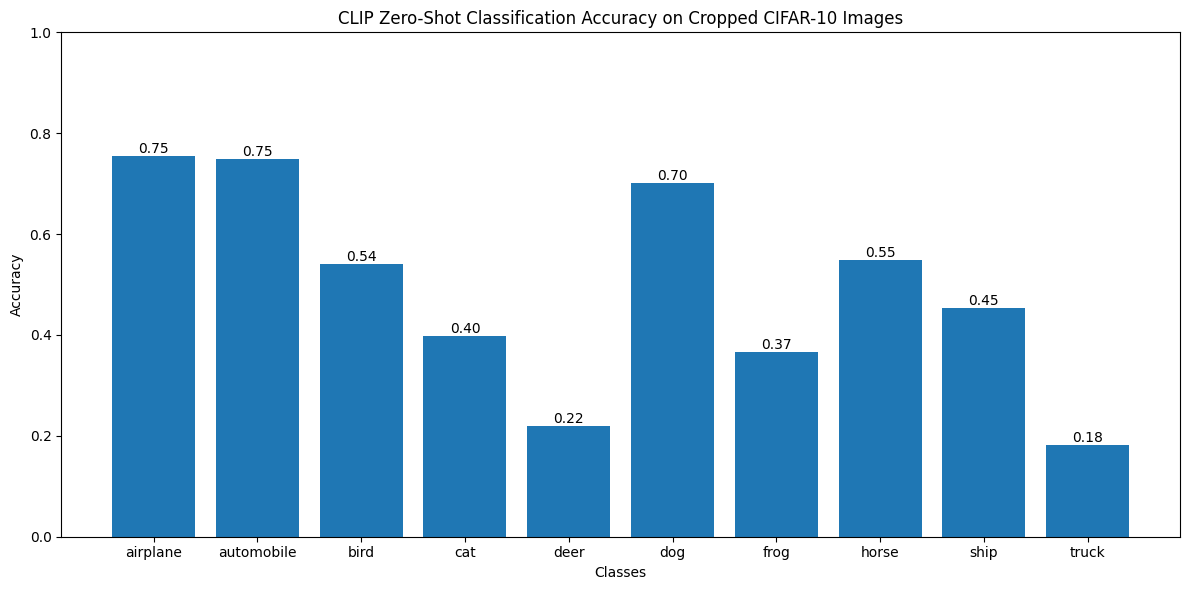

Overall Accuracy on Cropped Images: 0.4913


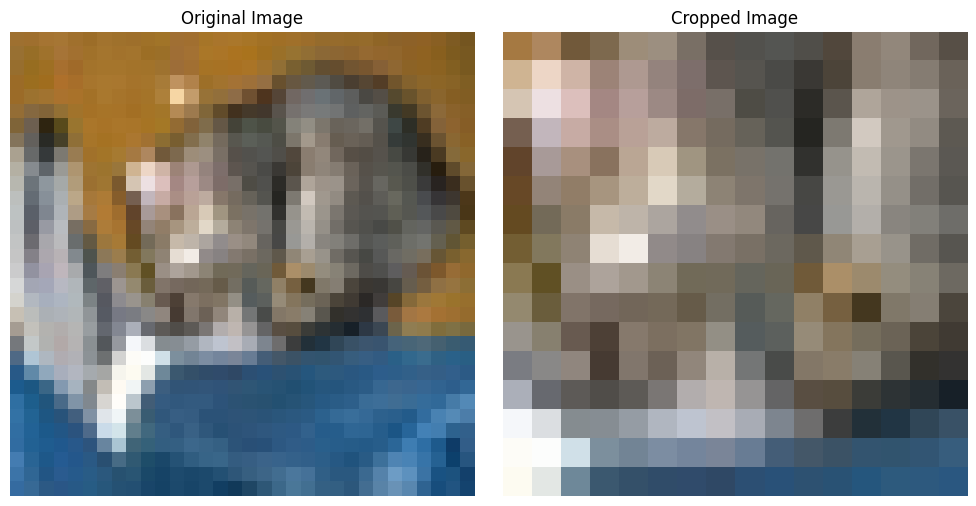

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from transformers import CLIPProcessor, CLIPModel

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Load CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# CIFAR-10 classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Prepare text inputs
text_inputs = processor(text=["a photo of a " + c for c in classes], padding=True, return_tensors="pt")

# Function to crop image
def crop_image(img, crop_percent=0.25):
    w, h = img.size
    crop_w = int(w * crop_percent)
    crop_h = int(h * crop_percent)
    return img.crop((crop_w, crop_h, w - crop_w, h - crop_h))

correct_predictions = {c: 0 for c in classes}
total_predictions = {c: 0 for c in classes}

# Evaluate on test set
model.eval()
with torch.no_grad():
    for images, labels in testloader:
        batch_size = images.shape[0]
        
        # Process images
        images = [(img.permute(1, 2, 0).numpy() * 0.5 + 0.5) * 255 for img in images]
        images = [Image.fromarray(img.astype(np.uint8)) for img in images]
        
        # Crop images
        images = [crop_image(img) for img in images]
        
        image_inputs = processor(images=images, return_tensors="pt", padding=True)
        
        # Get model outputs
        outputs = model(**image_inputs, **text_inputs)
        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=1)
        
        # Get predictions
        predictions = torch.argmax(probs, dim=1)
        
        # Update correct predictions and total predictions
        for pred, label in zip(predictions, labels):
            pred_class = classes[pred]
            true_class = classes[label]
            total_predictions[true_class] += 1
            if pred_class == true_class:
                correct_predictions[true_class] += 1

# Calculate accuracy for each class
accuracies = {c: correct_predictions[c] / total_predictions[c] for c in classes}

# Plot results
plt.figure(figsize=(12, 6))
plt.bar(classes, list(accuracies.values()))
plt.title("CLIP Zero-Shot Classification Accuracy on Cropped CIFAR-10 Images")
plt.xlabel("Classes")
plt.ylabel("Accuracy")
plt.ylim(0, 1)

for i, (c, acc) in enumerate(accuracies.items()):
    plt.text(i, acc, f"{acc:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print overall accuracy
overall_accuracy = sum(correct_predictions.values()) / sum(total_predictions.values())
print(f"Overall Accuracy on Cropped Images: {overall_accuracy:.4f}")

# Visualize an example of original vs cropped image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
original_img = Image.fromarray(((testset[0][0].permute(1, 2, 0).numpy() * 0.5 + 0.5) * 255).astype(np.uint8))
plt.imshow(original_img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
cropped_img = crop_image(original_img)
plt.imshow(cropped_img)
plt.title("Cropped Image")
plt.axis('off')

plt.tight_layout()
plt.show()